# Script to evaluate the ML-Models

Setup (load automl-models.pickle)

In [10]:
import _pickle as cPickle
import csv

with open(r"../app/_meta.csv") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  list_qualities = list()
  for line in csv_reader:
    list_qualities.append(line[0])
  list_qualities = list_qualities[1:]

with open(r"../app/ml-models.pickle", "rb") as input_file:
  ml_models = cPickle.load(input_file)

list_qualities

['AutoCorrelation',
 'CfsSubsetEval_DecisionStumpAUC',
 'CfsSubsetEval_DecisionStumpErrRate',
 'CfsSubsetEval_DecisionStumpKappa',
 'CfsSubsetEval_NaiveBayesAUC',
 'CfsSubsetEval_NaiveBayesErrRate',
 'CfsSubsetEval_NaiveBayesKappa',
 'CfsSubsetEval_kNN1NAUC',
 'CfsSubsetEval_kNN1NErrRate',
 'CfsSubsetEval_kNN1NKappa',
 'ClassEntropy',
 'DecisionStumpAUC',
 'DecisionStumpErrRate',
 'DecisionStumpKappa',
 'Dimensionality',
 'EquivalentNumberOfAtts',
 'J48.00001.AUC',
 'J48.00001.ErrRate',
 'J48.00001.Kappa',
 'J48.0001.AUC',
 'J48.0001.ErrRate',
 'J48.0001.Kappa',
 'J48.001.AUC',
 'J48.001.ErrRate',
 'J48.001.Kappa',
 'MajorityClassPercentage',
 'MajorityClassSize',
 'MaxAttributeEntropy',
 'MaxKurtosisOfNumericAtts',
 'MaxMeansOfNumericAtts',
 'MaxMutualInformation',
 'MaxNominalAttDistinctValues',
 'MaxSkewnessOfNumericAtts',
 'MaxStdDevOfNumericAtts',
 'MeanAttributeEntropy',
 'MeanKurtosisOfNumericAtts',
 'MeanMeansOfNumericAtts',
 'MeanMutualInformation',
 'MeanNoiseToSignalRatio',


Inspect the score:

In [38]:
sum_scores = 0
for key, value in ml_models.items():
  print(key, ':', value.get('score'))
  sum_scores += value.get('score')
print()
print('Average:', "{:.2f}".format(100*sum_scores/len(ml_models), 2), '%')

TPOT : 0.85
auto-sklearn : 0.95
hyperopt. : 0.95
rminer AutoML : 1.0
H2O AutoML : 0.85
FLAML : 0.7
AutoGluon : 1.0
ATM : 0.7
TransmogrifAI : 1.0

Average: 88.89 %


Test with a random dataset:

In [18]:
import openml as oml
import pandas as pd

In [28]:
dataset = oml.datasets.get_dataset(12)

In [29]:
t = dict()

for quality in list_qualities:
  t[quality] = [dataset.qualities.get(quality)]
test_df = pd.DataFrame(t)

for key, value in ml_models.items():
  aml = value.get('model')
  print(key, ':', aml.predict(test_df))

TPOT : [0]
auto-sklearn : [0]
hyperopt. : [0]
rminer AutoML : [0]
H2O AutoML : [0]
FLAML : [1]
AutoGluon : [0]
ATM : [0]
TransmogrifAI : [0]


In [12]:
for key, value in ml_models.items():
  aml = value.get('model')
  print(key, ':', aml.best_estimator)

TPOT : lgbm
auto-sklearn : lgbm
hyperopt. : xgboost
rminer AutoML : xgboost
H2O AutoML : rf
FLAML : xgb_limitdepth
AutoGluon : rf
ATM : lgbm
TransmogrifAI : lgbm


In [63]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

results = dict()

for key in ml_models.keys():
  flaml_dict = ml_models.get(key)
  model, X, y = flaml_dict.get('model'), flaml_dict.get('X'), flaml_dict.get('y')
  np.nan_to_num(X)
  result = permutation_importance(model, X, y)
  results[key] = result

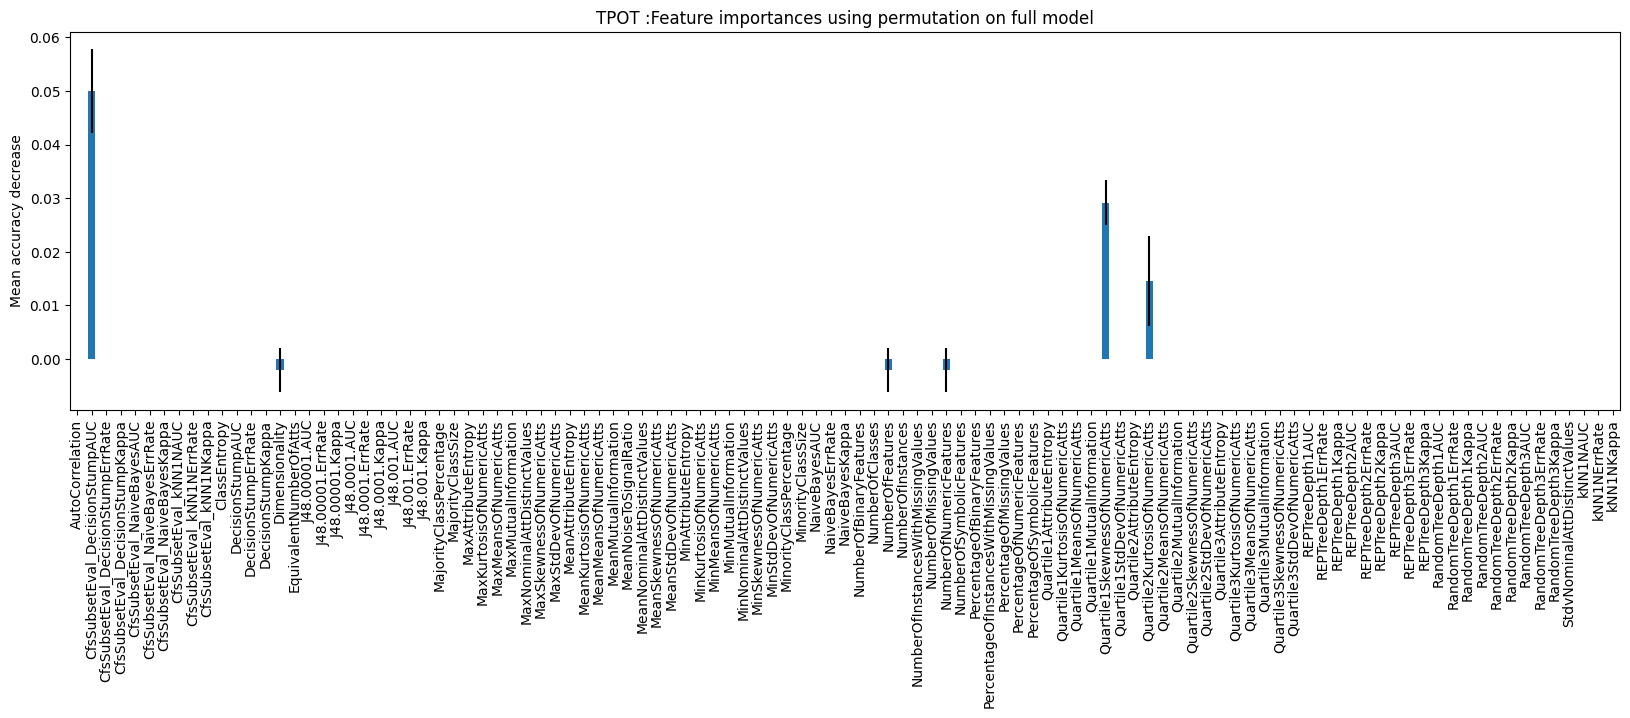

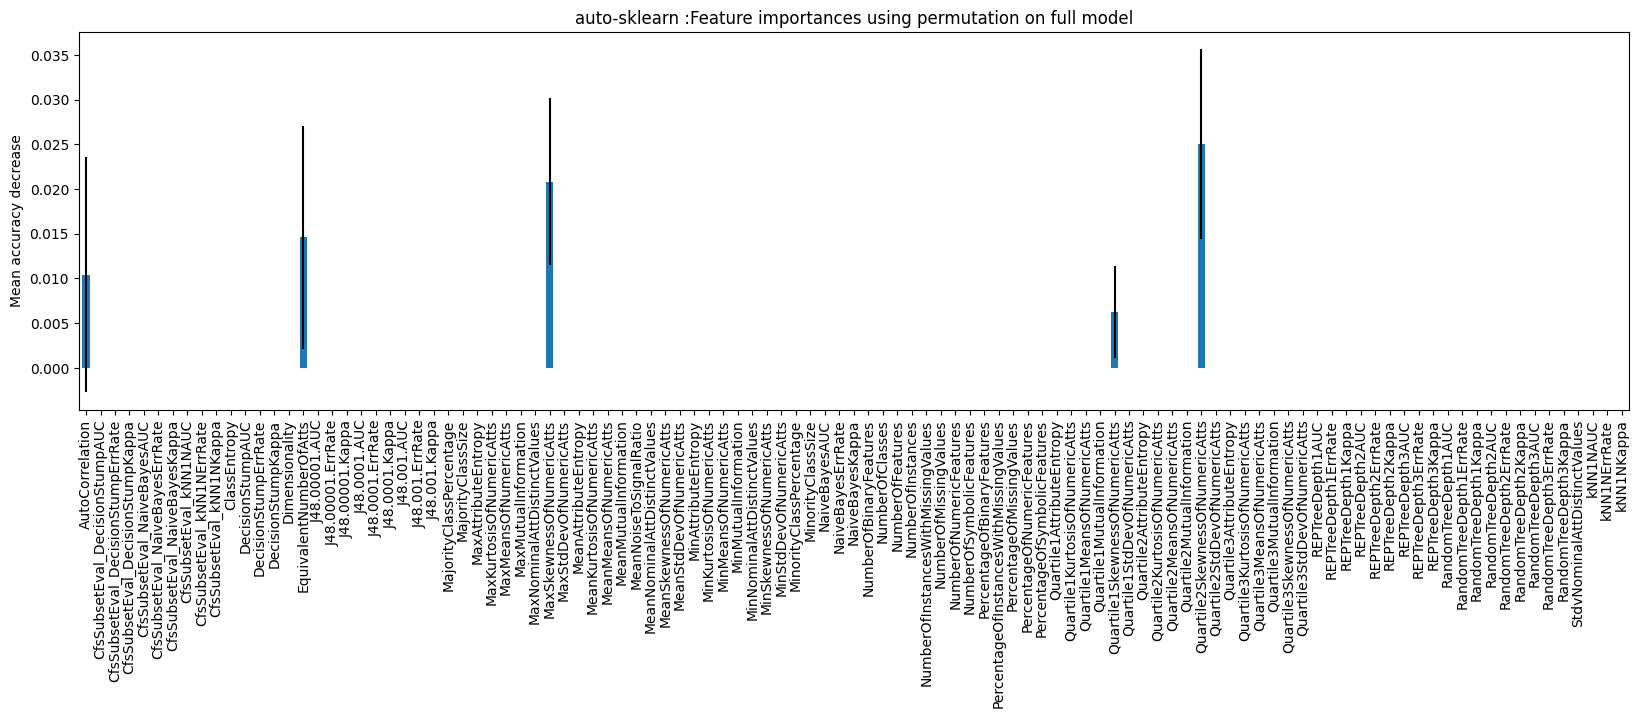

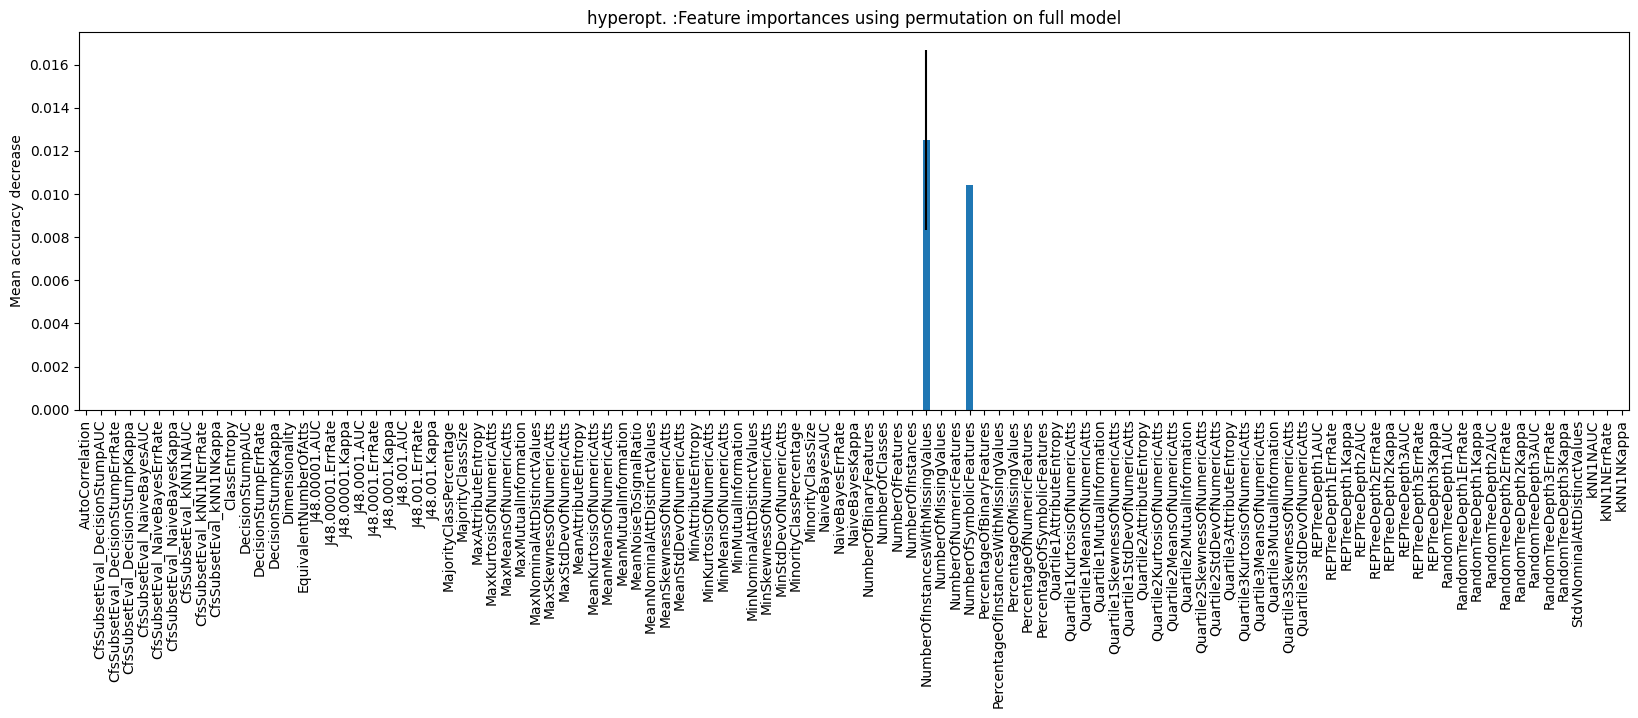

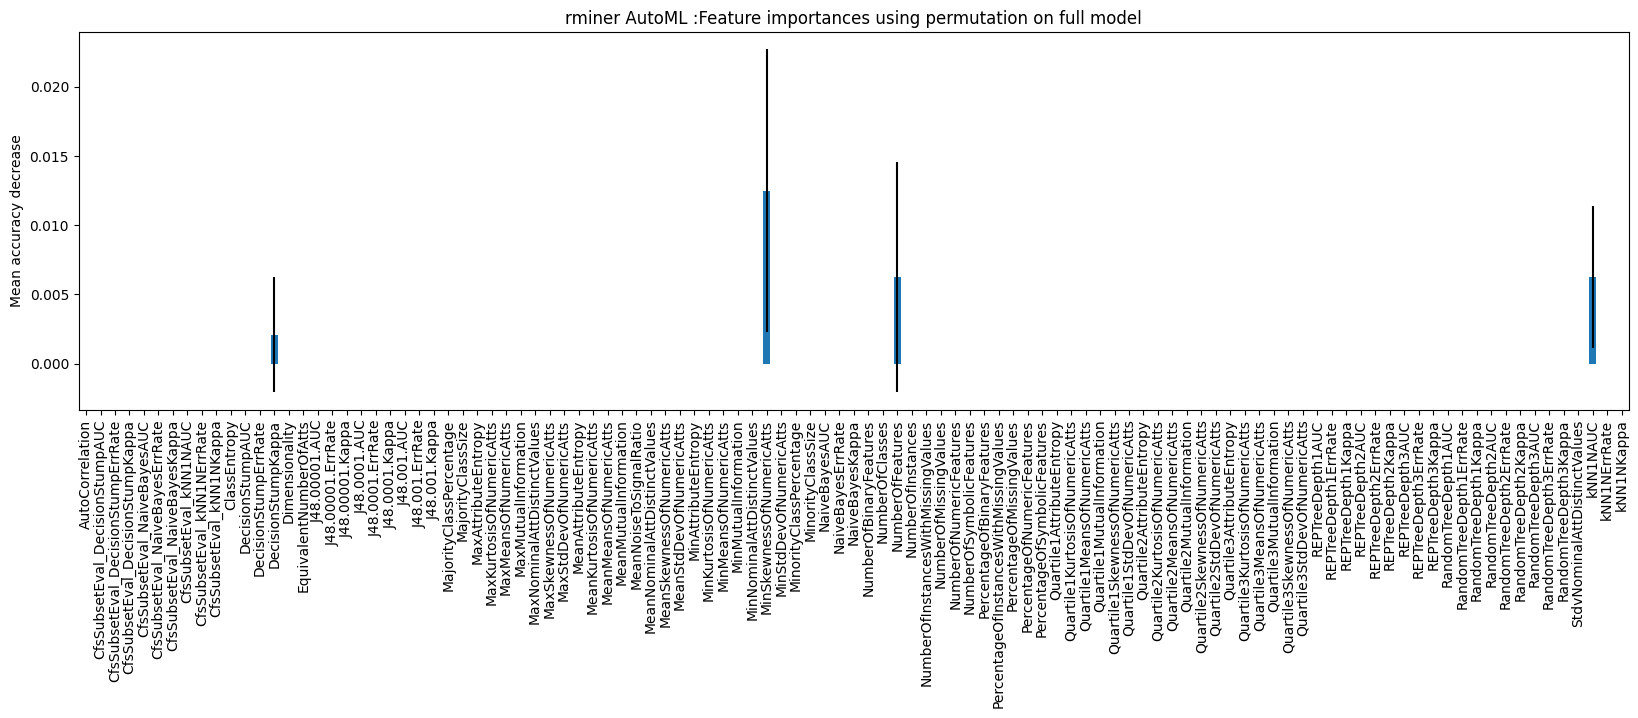

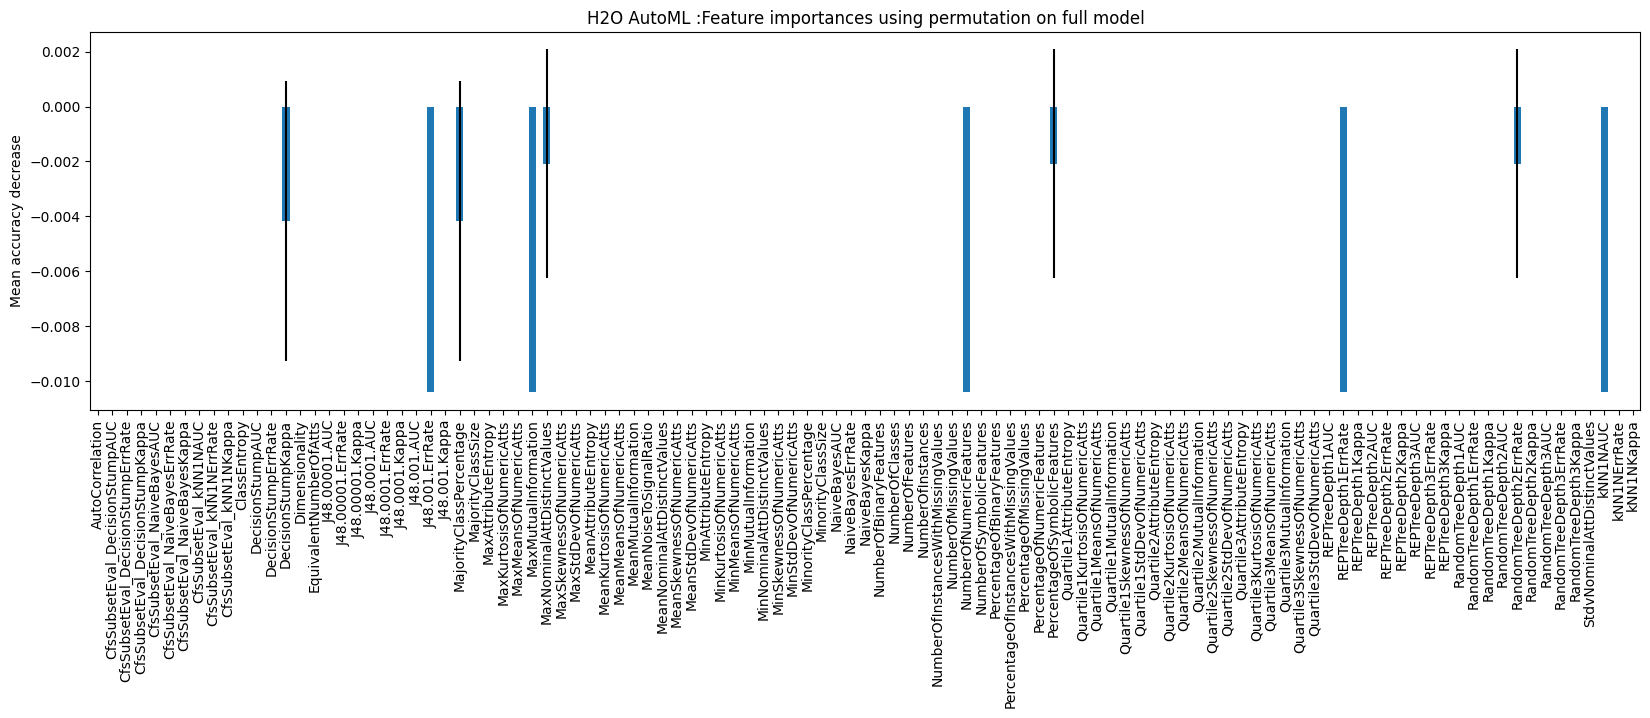

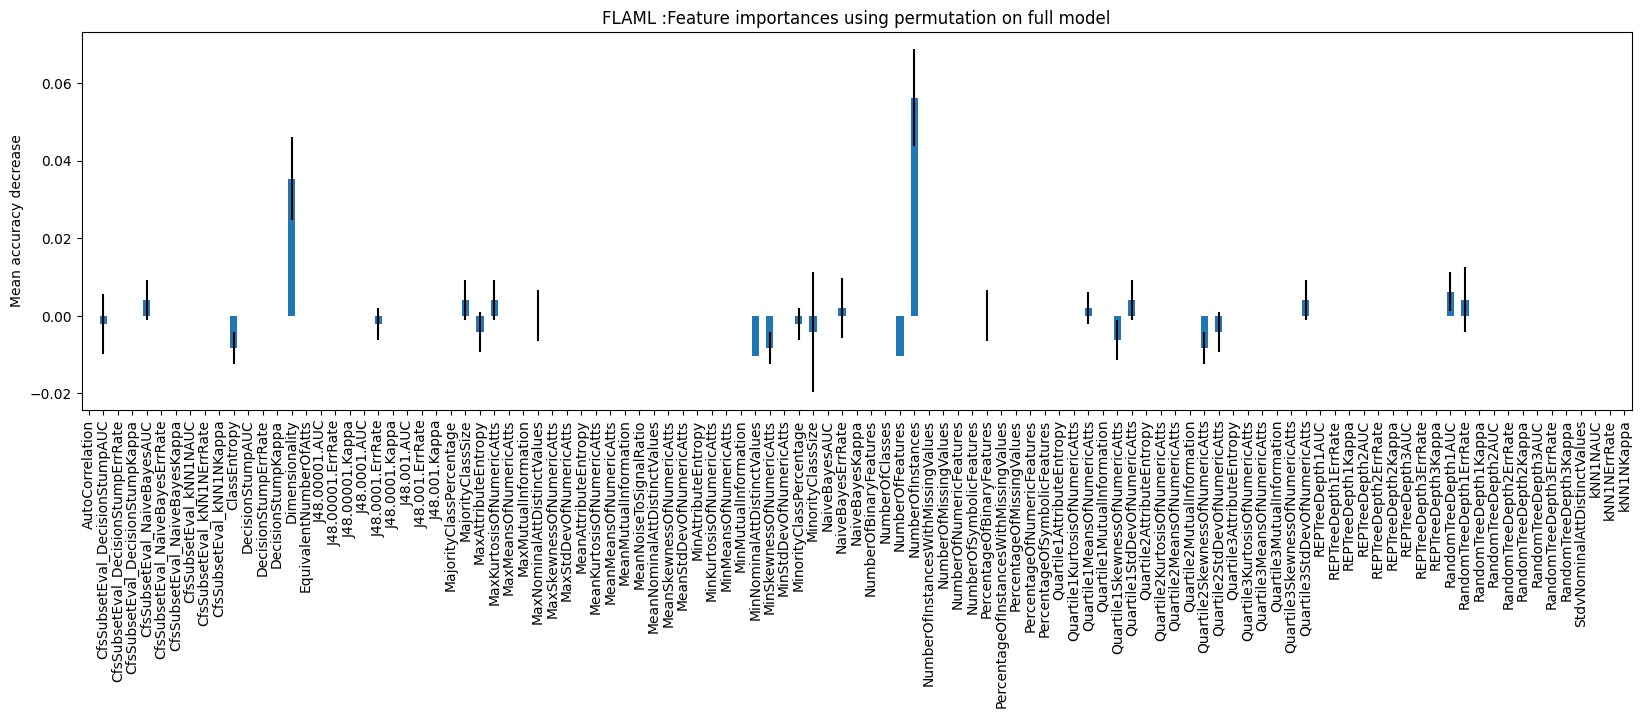

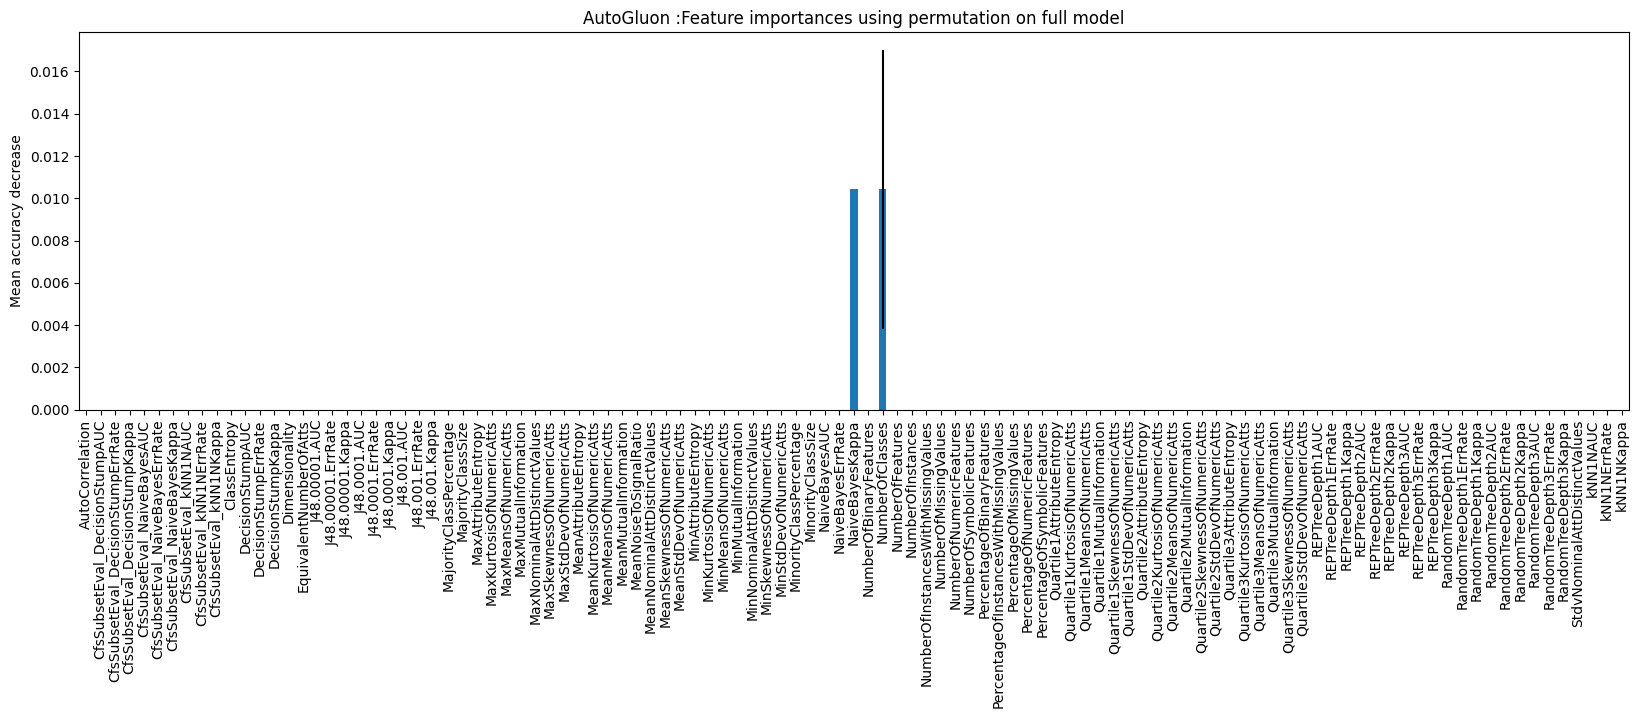

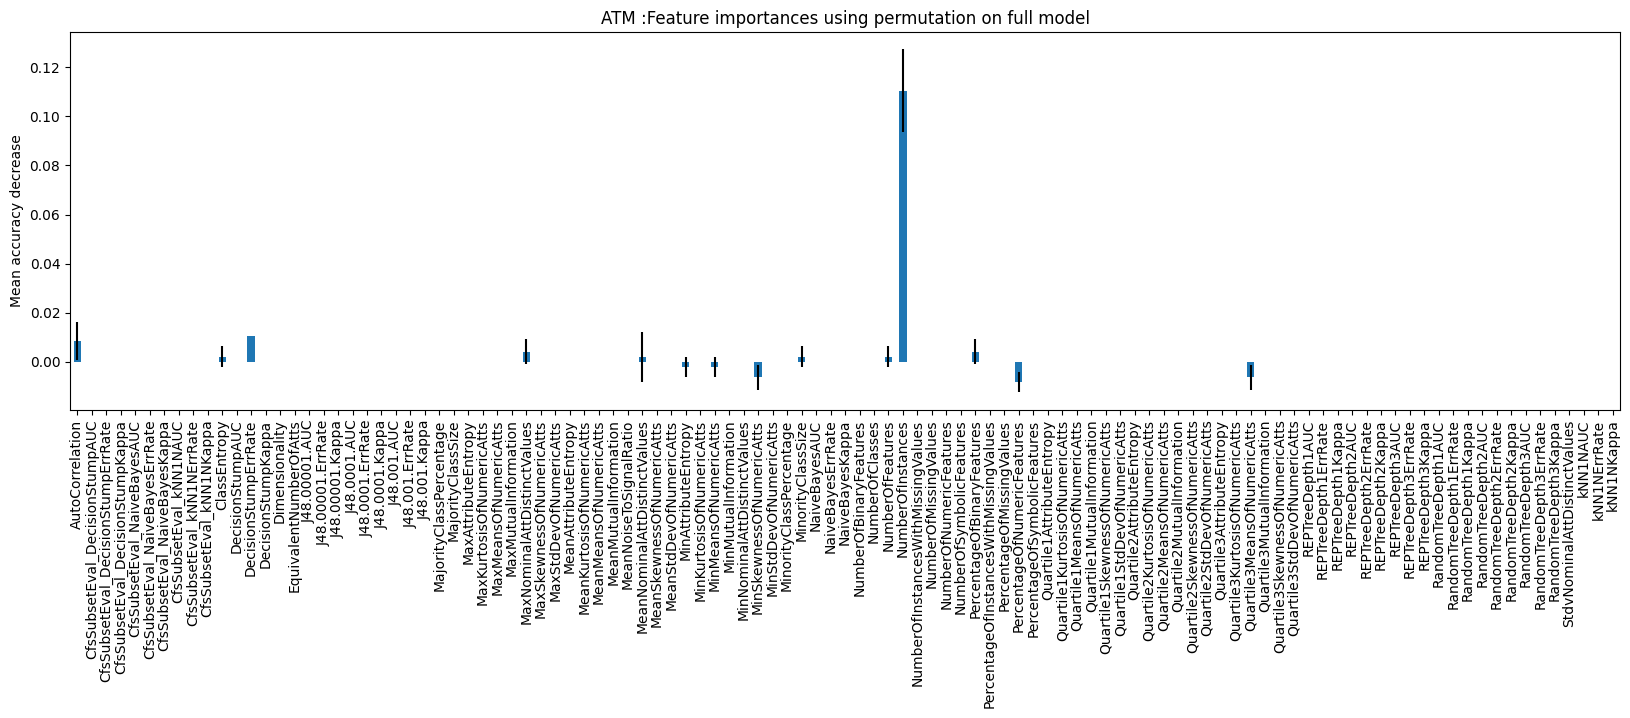

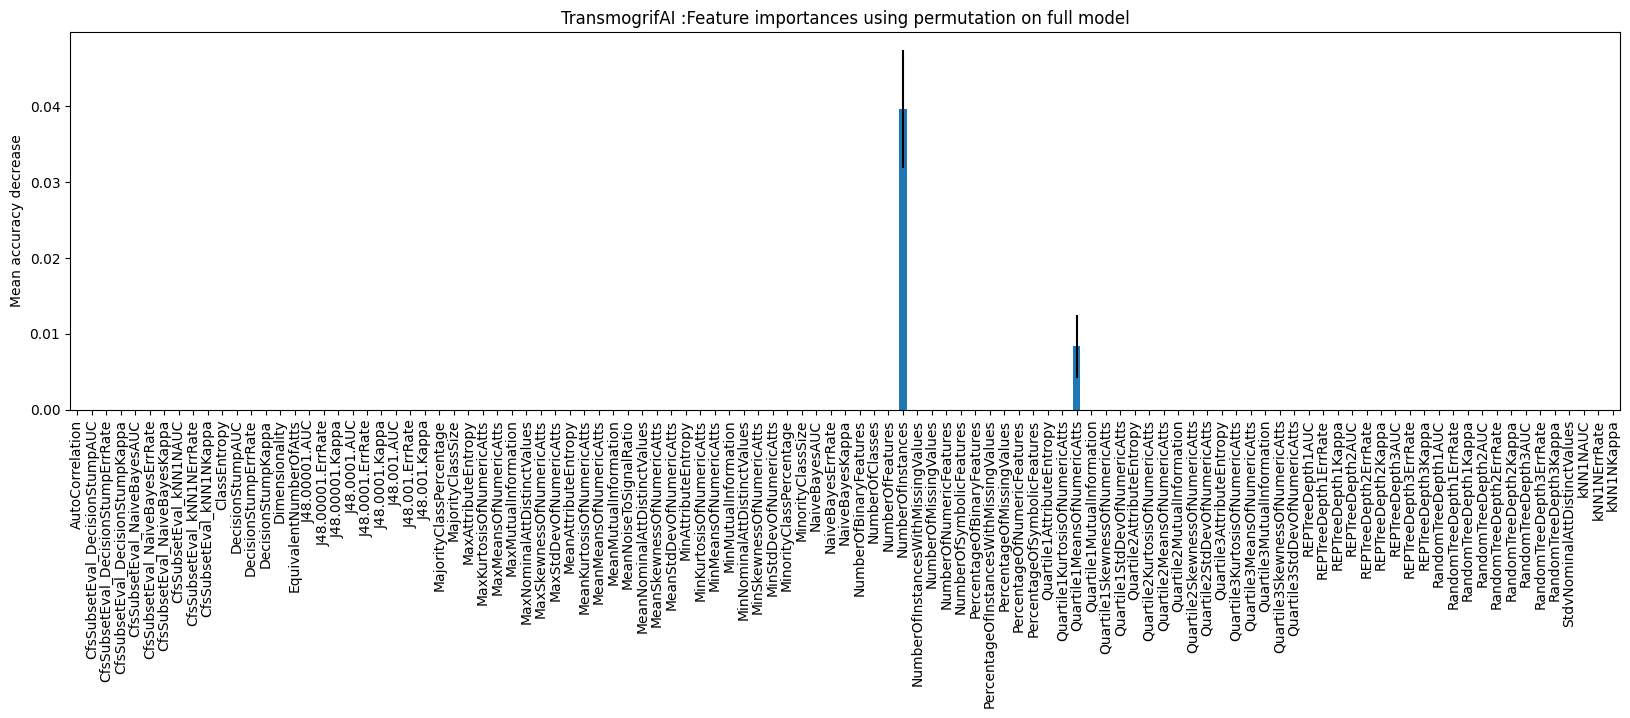

In [66]:
import matplotlib.pyplot as plt

for key, result in results.items(): 
  fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
  ax.set_title(key + " :Feature importances using permutation on full model")
  ax.set_ylabel("Mean accuracy decrease")
  forest_importances = pd.Series(result.importances_mean, index=list_qualities)
  forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

plt.show()